#Classificação de Cogumelos

## Carregar base de Dados

In [1]:
# Importação dos pacotes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('mushrooms.xlsx')
data.head()

,cap.shape,cap.surface,cap.color,bruises,odor,gill.attachment,gill.spacing,gill.size,gill.color,stalk.shape,stalk.root,stalk.surface.above.ring,stalk.surface.below.ring,stalk.color.above.ring,stalk.color.below.ring,veil.color,ring.number,ring.type,spore.print.color,population,habitat.,class
0,BELL,SCALY,BUFF,BRUISES,NONE,FREE,CLOSE,BROAD,WHITE,ENLARGING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,WHITE,TWO,PENDANT,GREEN,SEVERAL,GRASSES,POISONOUS
1,CONVEX,SMOOTH,WHITE,NO,NONE,FREE,CROWDED,BROAD,BROWN,TAPERING,EQUAL,FIBROUS,SMOOTH,WHITE,WHITE,WHITE,ONE,EVANESCENT,BLACK,ABUNDANT,GRASSES,EDIBLE
2,FLAT,SMOOTH,WHITE,NO,NONE,FREE,CROWDED,BROAD,BROWN,TAPERING,EQUAL,FIBROUS,SMOOTH,WHITE,WHITE,WHITE,ONE,EVANESCENT,BLACK,ABUNDANT,GRASSES,EDIBLE
3,CONVEX,FIBROUS,BROWN,NO,NONE,FREE,CLOSE,NARROW,BLACK,ENLARGING,EQUAL,SMOOTH,SMOOTH,WHITE,WHITE,WHITE,ONE,PENDANT,BROWN,SOLITARY,URBAN,EDIBLE
4,FLAT,FIBROUS,BROWN,BRUISES,NONE,FREE,CLOSE,BROAD,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,PINK,WHITE,ONE,PENDANT,BROWN,SOLITARY,WOODS,EDIBLE


In [3]:
data.describe()

,cap.shape,cap.surface,cap.color,bruises,odor,gill.attachment,gill.spacing,gill.size,gill.color,stalk.shape,stalk.root,stalk.surface.above.ring,stalk.surface.below.ring,stalk.color.above.ring,stalk.color.below.ring,veil.color,ring.number,ring.type,spore.print.color,population,habitat.,class
count,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936,5936
unique,6,4,8,2,7,2,2,2,9,2,4,4,4,7,7,2,3,4,6,6,6,2
top,CONVEX,FIBROUS,GRAY,BRUISES,NONE,FREE,CLOSE,BROAD,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS,EDIBLE
freq,2980,2300,1952,3184,3056,5912,4632,5208,1448,3136,3800,3876,3684,3416,3344,5928,5768,3488,2048,2184,2504,3768


##Análise exploratória

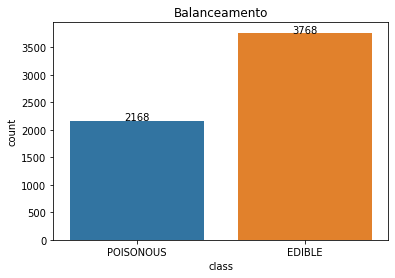

In [4]:
# Balanceamento
graph = sns.countplot(data=data, x='class')
plt.title('Balanceamento')

for idx, bar in enumerate(graph.patches):
    height = bar.get_height()
    graph.text(x=bar.get_x() + bar.get_width()/2., y=height + 0.1, s=(data['class'].value_counts()).sort_values()[idx], ha="center")

plt.show()

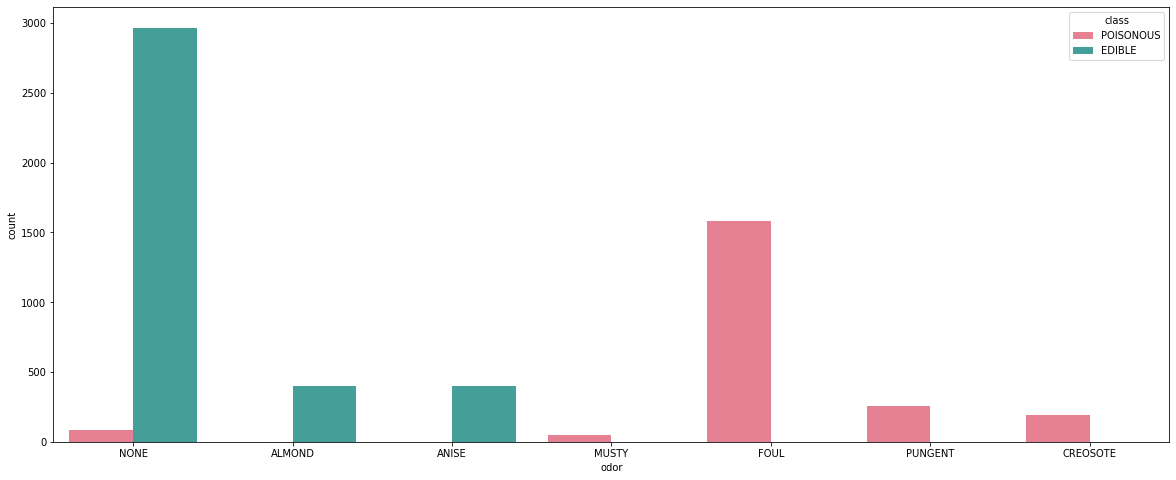

In [5]:
# Atributo odor
plt.figure(figsize=(20,8))
sns.countplot(data=data, x='odor', hue='class', palette='husl')
plt.show()

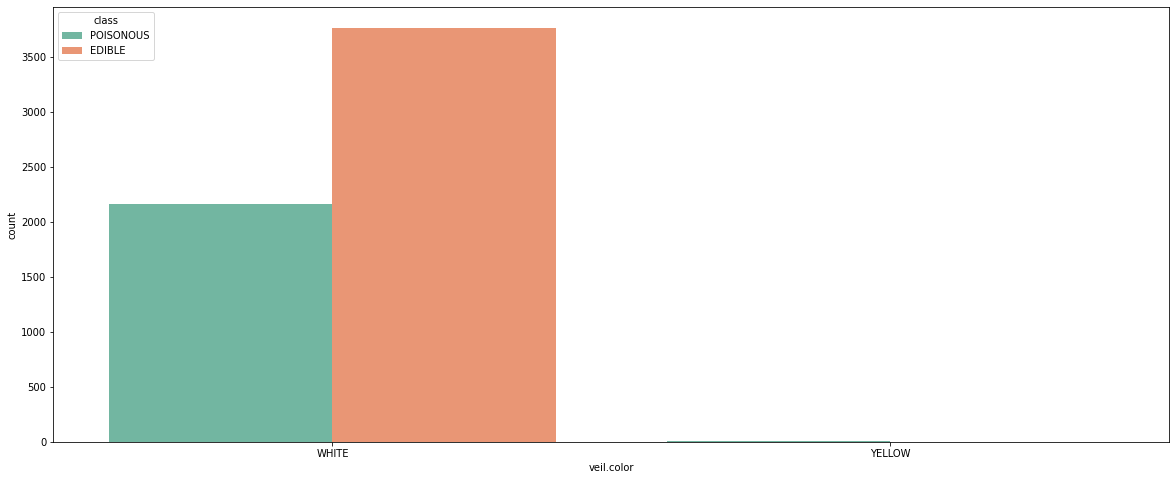

In [6]:
# Atributo veil.color
plt.figure(figsize=(20,8))
sns.countplot(data=data, x='veil.color', hue='class', palette='Set2')
plt.show()

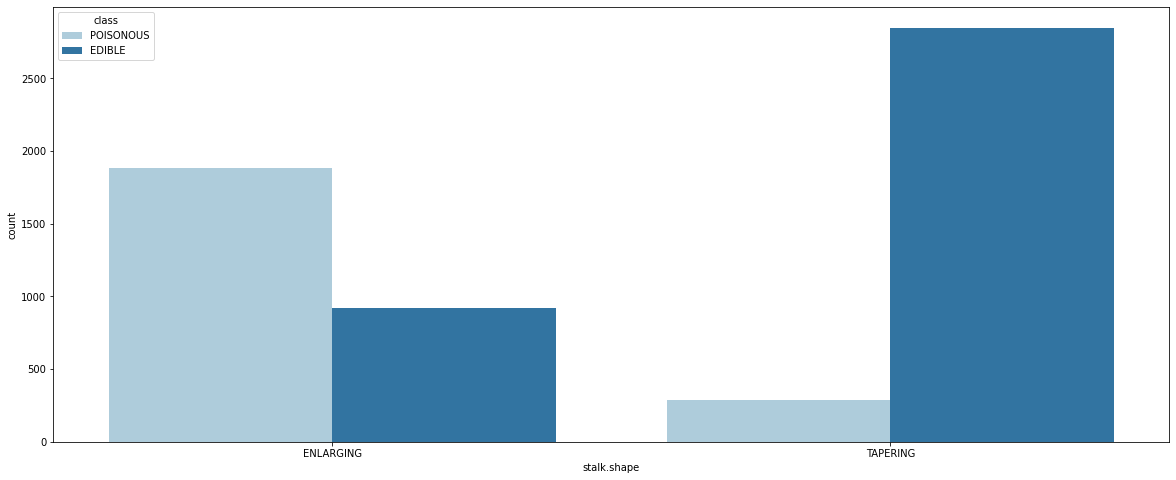

In [7]:
# Atributo stalk.shape
plt.figure(figsize=(20,8))
sns.countplot(data=data, x='stalk.shape', hue='class', palette='Paired')
plt.show()

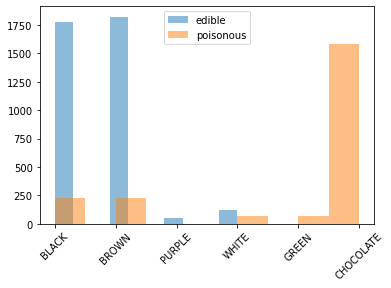

In [8]:
edible = data[data['class'] == 'EDIBLE']
poisonous = data[data['class'] == 'POISONOUS']

plt.hist(edible['spore.print.color'], alpha=0.5, label='edible')
plt.hist(poisonous['spore.print.color'],  alpha=0.5, label='poisonous')
plt.xticks(rotation=45);
plt.legend()
plt.show()

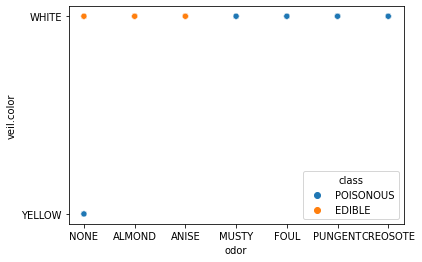

In [9]:
sns.scatterplot(data=data, x='odor', y='veil.color', hue='class')
plt.show()

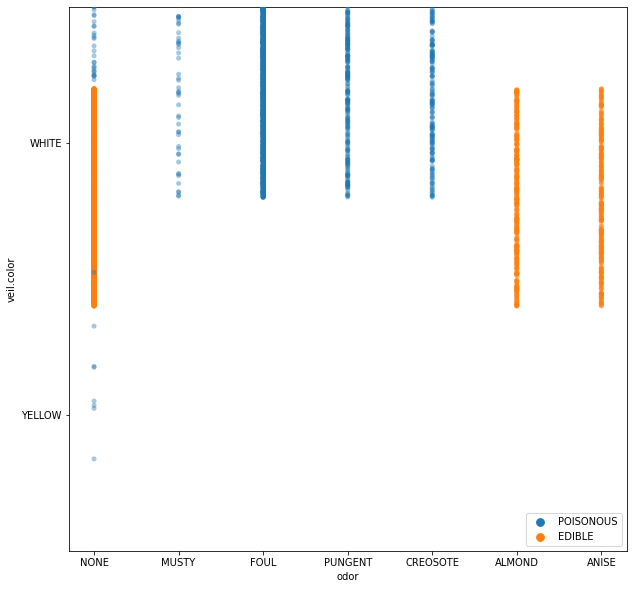

In [10]:
plt.figure(figsize=(10,10))
sns.stripplot(data=data, x='odor', y='veil.color', hue='class', jitter=0.8, dodge=True, orient='h', alpha=0.4)

plt.legend(loc='lower right')
plt.show()

##Machine Learning

## Separar bases de treino e teste

In [11]:
# semente para reprodução de resultados
seed=10000

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,data.columns != 'class'], data['class'], test_size=0.2, stratify=data['class'], random_state=seed)

print('shape input de treino: ', X_train.shape)
print('shape input de teste: ', X_test.shape)
print('shape output de treino: ', y_train.shape)
print('shape output de teste: ', y_test.shape)

shape input de treino:  (4748, 21)
shape input de teste:  (1188, 21)
shape output de treino:  (4748,)
shape output de teste:  (1188,)


In [12]:
# Verificar proporções. amostragem estratificada
data['class'].value_counts()

EDIBLE       3768
POISONOUS    2168
Name: class, dtype: int64

In [13]:
#treino
print(0.8 * data['class'].value_counts()[0])
print(0.8 * data['class'].value_counts()[1])

#test
print(0.2 * data['class'].value_counts()[0])
print(0.2 * data['class'].value_counts()[1])

3014.4
1734.4
753.6
433.6


In [14]:
y_train.value_counts()

EDIBLE       3014
POISONOUS    1734
Name: class, dtype: int64

In [15]:
y_test.value_counts()

EDIBLE       754
POISONOUS    434
Name: class, dtype: int64

## Árvore de Decisão

In [16]:
# Trasnformar inputs categóricos em numérico: dummy coding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [17]:
X_train.shape

(4748, 76)

In [18]:
# treinar modelo
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(min_samples_leaf=5, random_state=seed) # tente mudar parâmetro para evitar overfitting
model.fit(X_train, y_train);

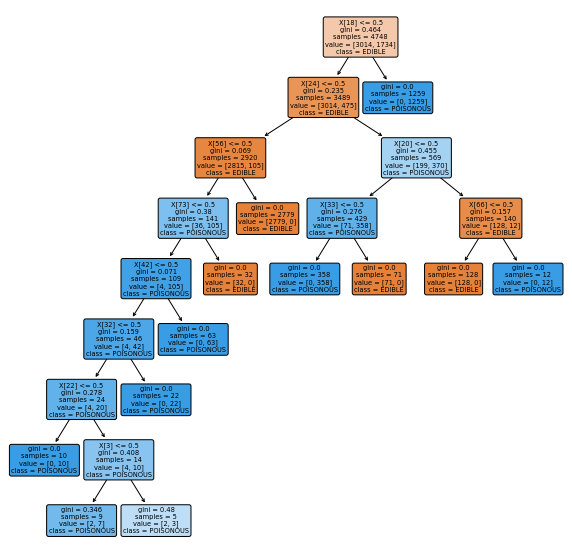

In [19]:
# Visualização gráfica da árvore de decisão
from sklearn import tree
fig, ax = plt.subplots(figsize=(10, 10)) # Definir tamanho da imagem a ser gerada
tree.plot_tree(model, class_names=y_train.unique(), filled=True, rounded=True); # plota a árvore

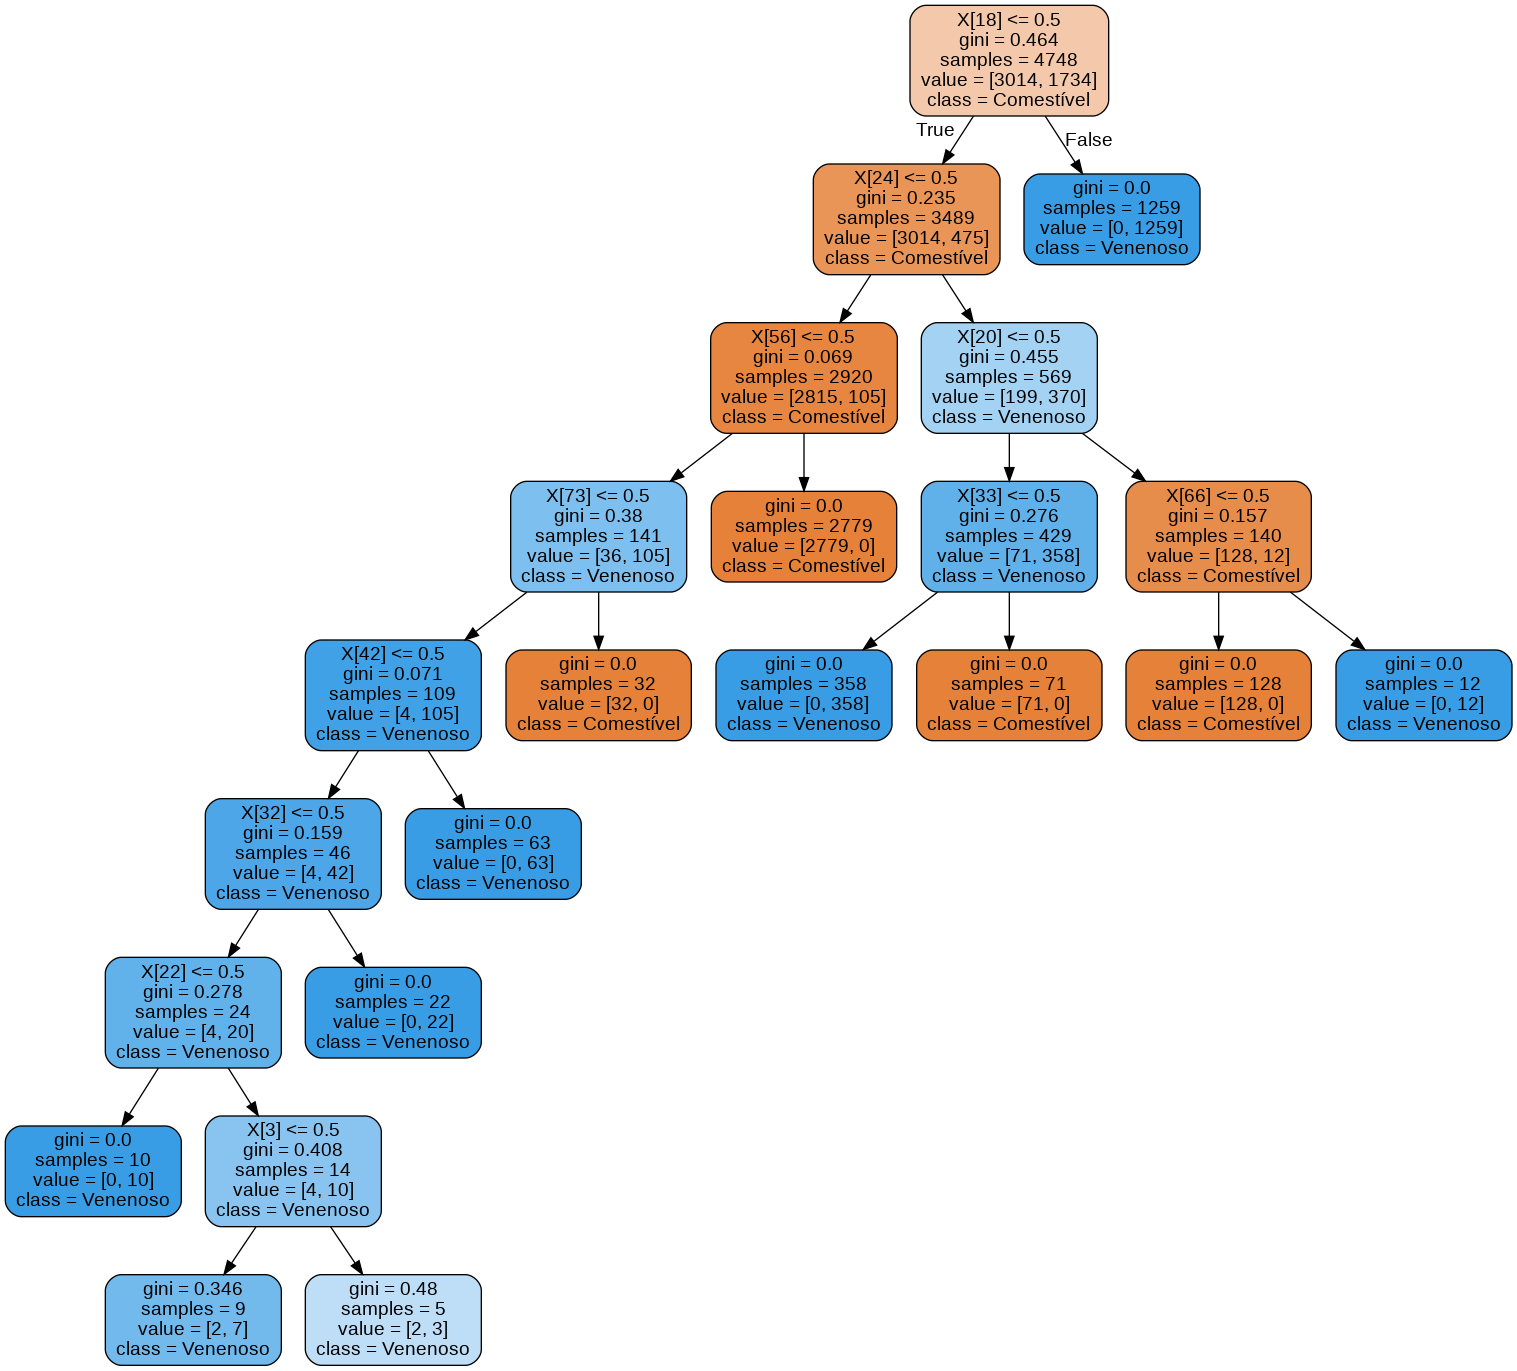

In [20]:
# OUUU
# Visualização gráfica da árvore de decisão
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(model, #feature_names=list(pd.DataFrame(X_train).columns.values), 
                           class_names=['Comestível', 'Venenoso'], rounded=True, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [21]:
# métrica de treino
model.score(X_train, y_train)

0.9991575400168492

In [22]:
# Avaliar modelo treinado na base de teste
model.score(X_test, y_test) # acurácia

0.9966329966329966

In [23]:
y_pred = model.predict(X_test) #inferência do teste

In [24]:
import numpy as np
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print("Frequência:")
print(np.asarray((unique_elements, counts_elements)))

Frequência:
[['EDIBLE' 'POISONOUS']
 [754 434]]


In [25]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
confMatrix = confusion_matrix(y_pred, y_test)
pd.DataFrame(confMatrix, index=['Previsto comestível', 'Previsto venenoso'], columns=['Real comestível', 'Real venenoso'])

,Real comestível,Real venenoso
Previsto comestível,750,0
Previsto venenoso,4,434


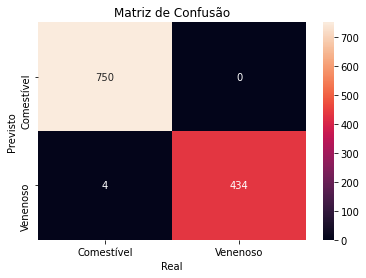

In [26]:
ax = plt.subplot()
sns.heatmap(confMatrix, annot=True, fmt=".0f")
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusão')

# Colocar os nomes
ax.xaxis.set_ticklabels(['Comestível', 'Venenoso']) 
ax.yaxis.set_ticklabels(['Comestível', 'Venenoso'])
plt.show()